#CI Project - NLP
---
##LSTM Models

In [ ]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
from keras.utils import to_categorical

## Loading Dataset
---

In [ ]:
data = pd.read_csv("sentiment.csv")

In [ ]:
classes = ["Negative", "Neutral", "Positive"]

text = data['text']
labels = data['sentiment']

##Preprocess
---

In [ ]:
import re

import nltk
import numpy as np
from nltk.corpus import stopwords
from keras.utils import to_categorical

nltk.download('stopwords')
from typing import List

def to_lower(text):
    return text.lower()

def remove_punct(text: str) -> str:
    """Removes punctuation symbols from text.

    Parameters
    ----------
    text : str
        Input text

    Returns
    -------
    str
        Processed string
    """
    return re.sub('[^a-zA-z0-9\s]', '', text)

def remove_stopwords(text: str) -> str:
    """Removes words with high frequency in text but low semantic values.

    Parameters
    ----------
    text : str
        Input text

    Returns
    -------
    str
        Processed text
    """
    stop_words = set(stopwords.words('english'))
    return " ".join([word for word in text.split() if word not in stop_words])

def remove_prefix(text: str) -> str:
    """Removes some common twitter prefixes such as "rt" as a sign of the post being retweeted.

    Parameters
    ----------
    text : str
        Input text

    Returns
    -------
    str
        Processed text
    """
    if text.startswith("rt"):
        text = text[2:]
    return text

def convert_labels_to_numerical(label: str, classes: List[str]) -> int:
    """Converts the string categorical label to a numerical label.

    Parameters
    ----------
    label : str
        Categorical label
    classes : List[str]
        List of categories

    Returns
    -------
    int
        Numerical label
    """
    return classes.index(label)

def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

def clean_data(raw_data, labels):
    # Clean text
    data = raw_data.apply(to_lower)
    data = data.apply(remove_punct)
    data = data.apply(remove_emojis)
    data = data.apply(remove_prefix)
    # data = data.apply(remove_stopwords)
    data = list(data)
    # Clean labels
    classes = ["Negative", "Neutral", "Positive"]
    labels = np.array([convert_labels_to_numerical(label, classes) for label in labels])
    labels = to_categorical(labels, num_classes=3)
    return data, labels

def clean_test_data(raw_data, labels):
    # Clean text
    data = raw_data.apply(to_lower)
    data = data.apply(remove_punct)
    data = data.apply(remove_emojis)
    data = data.apply(remove_prefix)
    # data = data.apply(remove_stopwords)
    data = list(data)
    # Clean labels
    labels = to_categorical(labels, num_classes=3)
    return data, labels

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
cleaned_text, label = clean_data(text, labels)
cleaned_test, test_label = clean_test_data(test_text, test_label)

In [ ]:
# Creating a bag of words
from collections import Counter

# Count unique words
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count


counter = counter_word(data['text'])

In [ ]:
num_unique_words = len(counter)

In [ ]:
# Splitting data into train and test
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(np.array(cleaned_text), label, test_size=0.2)

In [ ]:
print(f"Number of train samples: {len(train_sentences)}")
print(f"Number of validation samples: {len(val_sentences)}")

Number of train samples: 8752
Number of validation samples: 2189


In [ ]:
# Tokenize
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

# vectorize a text corpus by turning each text into a sequence of integers
tokenizer = Tokenizer(num_words=num_unique_words, )
tokenizer.fit_on_texts(train_sentences) # fit only to training
train_sequences = tokenizer.texts_to_sequences(train_sentences)
val_sequences = tokenizer.texts_to_sequences(val_sentences)
test_sequences = tokenizer.texts_to_sequences(np.array(cleaned_test))

# Max number of words in a sequence
max_length = np.max([len(i) for i in train_sequences])

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post", truncating="post")
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding="post", truncating="post")
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding="post", truncating="post")

In [ ]:
print(train_sentences[10])
print(train_sequences[10])
print(train_padded[10])

gopdebate foxnews failed httpstcogclqy4kaq5
[1, 48, 583, 4000]
[   1   48  583 4000    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]


## Training and Model Structure
---

###RNN
---

In [ ]:
# Create RNN model
from keras import layers
from keras import regularizers


model = keras.models.Sequential()
model.add(layers.Embedding(num_unique_words, 32, input_length=max_length, name="Embedding"))


model.add(layers.SimpleRNN(64, dropout=0.2, name="RNN_Block"))
model.add(layers.Dense(64, activation="relu", name="Hidden_Layer"))
model.add(layers.Dropout(0.2, name="Dropout"))
model.add(layers.Dense(3, activation="softmax", name="Classifier"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 29, 32)            953568    
                                                                 
 RNN_Block (SimpleRNN)       (None, 64)                6208      
                                                                 
 Hidden_Layer (Dense)        (None, 64)                4160      
                                                                 
 Dropout (Dropout)           (None, 64)                0         
                                                                 
 Classifier (Dense)          (None, 3)                 195       
                                                                 
Total params: 964,131
Trainable params: 964,131
Non-trainable params: 0
_________________________________________________________________


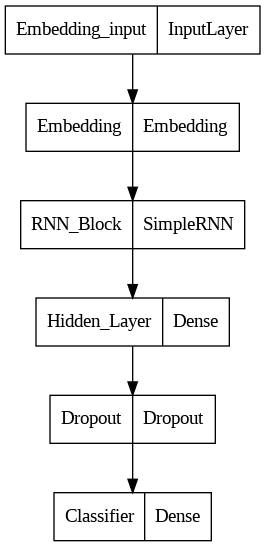

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
loss = keras.losses.CategoricalCrossentropy(from_logits=False)
optim = keras.optimizers.Adam(learning_rate=0.001)

metrics = [
        tf.keras.metrics.CategoricalAccuracy(name="accuracy", dtype=None),
        keras.metrics.Recall(name="recall"),
        keras.metrics.Precision(name="precision")
        ]

model.compile(loss=loss, optimizer=optim, metrics=metrics)
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('rnn_model_best.h5', save_best_only=True)
]

In [ ]:
history = model.fit(train_padded, train_labels, epochs=20, validation_data=(val_padded, val_labels), verbose=2, callbacks=callbacks)

Epoch 1/20
347/347 - 15s - loss: 0.8825 - accuracy: 0.6228 - recall: 0.4868 - precision: 0.6706 - val_loss: 0.8766 - val_accuracy: 0.6187 - val_recall: 0.4404 - val_precision: 0.7209 - 15s/epoch - 44ms/step
Epoch 2/20
347/347 - 12s - loss: 0.7140 - accuracy: 0.6928 - recall: 0.6018 - precision: 0.7650 - val_loss: 0.8168 - val_accuracy: 0.6368 - val_recall: 0.5611 - val_precision: 0.6929 - 12s/epoch - 34ms/step
Epoch 3/20
347/347 - 13s - loss: 0.4971 - accuracy: 0.8088 - recall: 0.7721 - precision: 0.8375 - val_loss: 0.9334 - val_accuracy: 0.6288 - val_recall: 0.5950 - val_precision: 0.6490 - 13s/epoch - 36ms/step
Epoch 4/20
347/347 - 12s - loss: 0.3501 - accuracy: 0.8746 - recall: 0.8554 - precision: 0.8914 - val_loss: 0.9938 - val_accuracy: 0.6058 - val_recall: 0.5643 - val_precision: 0.6292 - 12s/epoch - 34ms/step
Epoch 5/20
347/347 - 11s - loss: 0.2513 - accuracy: 0.9107 - recall: 0.8998 - precision: 0.9247 - val_loss: 1.1960 - val_accuracy: 0.6130 - val_recall: 0.5975 - val_precisi

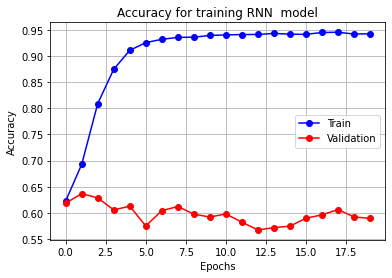

In [ ]:
plt.plot(history.history["accuracy"], 'b-o')
plt.plot(history.history["val_accuracy"], 'r-o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy for training RNN  model")
plt.legend(["Train", "Validation"])
plt.grid("on")
plt.savefig("rnn-finetune-accuracy.png")

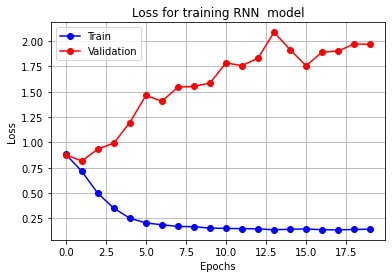

In [ ]:
plt.plot(history.history["loss"], 'b-o')
plt.plot(history.history["val_loss"], 'r-o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss for training RNN  model")
plt.legend(["Train", "Validation"])
plt.grid("on")
plt.savefig("rnn-finetune-loss.png")

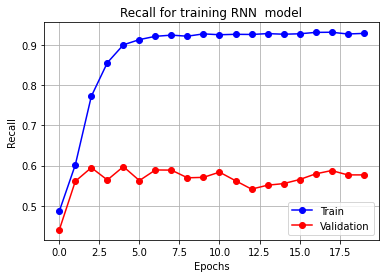

In [ ]:
plt.plot(history.history["recall"], 'b-o')
plt.plot(history.history["val_recall"], 'r-o')
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.title("Recall for training RNN  model")
plt.legend(["Train", "Validation"])
plt.grid("on")
plt.savefig("rnn-finetune-recall.png")

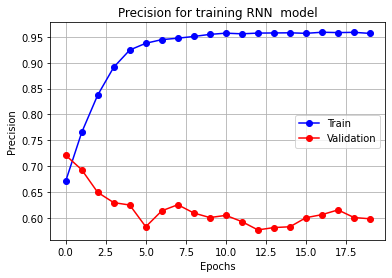

In [ ]:
plt.plot(history.history["precision"], 'b-o')
plt.plot(history.history["val_precision"], 'r-o')
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.title("Precision for training RNN  model")
plt.legend(["Train", "Validation"])
plt.grid("on")
plt.savefig("rnn-finetune-precision.png")

In [ ]:
model = keras.models.load_model('/content/rnn_model_best.h5')
model.evaluate(test_padded, test_label)

1/1 [==============================] - 0s 344ms/step - loss: 1.3008 - accuracy: 0.4500 - recall: 0.3500 - precision: 0.4667


[1.300750732421875,
 0.44999998807907104,
 0.3499999940395355,
 0.46666666865348816]

###LSTM
---

In [ ]:
# Create LSTM model
from keras import layers
from keras import regularizers


model = keras.models.Sequential()
model.add(layers.Embedding(num_unique_words, 32, input_length=max_length, name="Embedding"))

model.add(layers.LSTM(64, dropout=0.2, name="LSTM_Block"))
model.add(layers.Dense(64, activation="relu", name="Hidden_Layer"))
model.add(layers.Dropout(0.2, name="Dropout"))
model.add(layers.Dense(3, activation="softmax", name="Classifier"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 29, 32)            1013024   
                                                                 
 LSTM_Block (LSTM)           (None, 64)                24832     
                                                                 
 Hidden_Layer (Dense)        (None, 64)                4160      
                                                                 
 Dropout (Dropout)           (None, 64)                0         
                                                                 
 Classifier (Dense)          (None, 3)                 195       
                                                                 
Total params: 1,042,211
Trainable params: 1,042,211
Non-trainable params: 0
_________________________________________________________________


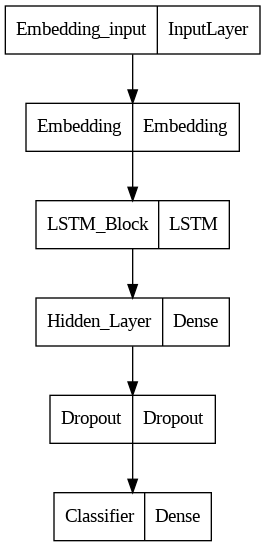

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
loss = keras.losses.CategoricalCrossentropy(from_logits=False)
optim = keras.optimizers.Adam(learning_rate=0.001)
metrics = [
        tf.keras.metrics.CategoricalAccuracy(name="accuracy", dtype=None),
        keras.metrics.Recall(name="recall"),
        keras.metrics.Precision(name="precision")
        ]
model.compile(loss=loss, optimizer=optim, metrics=metrics)
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('lstm_model_best.h5', save_best_only=True)
]

In [ ]:
history = model.fit(train_padded, train_labels, epochs=20, validation_data=(val_padded, val_labels), verbose=2, callbacks=callbacks)

Epoch 1/20
347/347 - 8s - loss: 0.8576 - accuracy: 0.6336 - recall: 0.5262 - precision: 0.6873 - val_loss: 0.7820 - val_accuracy: 0.6544 - val_recall: 0.5885 - val_precision: 0.7033 - 8s/epoch - 22ms/step
Epoch 2/20
347/347 - 2s - loss: 0.6712 - accuracy: 0.7185 - recall: 0.6238 - precision: 0.7862 - val_loss: 0.7389 - val_accuracy: 0.6825 - val_recall: 0.5809 - val_precision: 0.7508 - 2s/epoch - 7ms/step
Epoch 3/20
347/347 - 4s - loss: 0.5385 - accuracy: 0.7897 - recall: 0.7487 - precision: 0.8225 - val_loss: 0.7814 - val_accuracy: 0.6832 - val_recall: 0.6274 - val_precision: 0.7224 - 4s/epoch - 10ms/step
Epoch 4/20
347/347 - 2s - loss: 0.4213 - accuracy: 0.8479 - recall: 0.8225 - precision: 0.8691 - val_loss: 0.8984 - val_accuracy: 0.6796 - val_recall: 0.6530 - val_precision: 0.6972 - 2s/epoch - 6ms/step
Epoch 5/20
347/347 - 2s - loss: 0.3449 - accuracy: 0.8758 - recall: 0.8588 - precision: 0.8926 - val_loss: 0.9450 - val_accuracy: 0.6760 - val_recall: 0.6422 - val_precision: 0.6977 

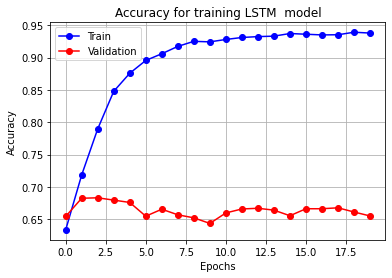

In [ ]:
plt.plot(history.history["accuracy"], 'b-o')
plt.plot(history.history["val_accuracy"], 'r-o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy for training LSTM  model")
plt.legend(["Train", "Validation"])
plt.grid("on")
plt.savefig("LSTM-finetune-accuracy.png")

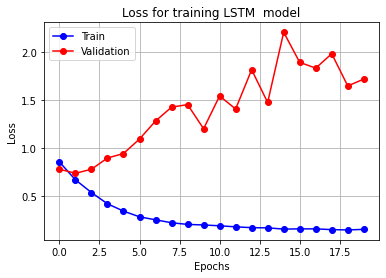

In [ ]:
plt.plot(history.history["loss"], 'b-o')
plt.plot(history.history["val_loss"], 'r-o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss for training LSTM  model")
plt.legend(["Train", "Validation"])
plt.grid("on")
plt.savefig("LSTM-finetune-loss.png")

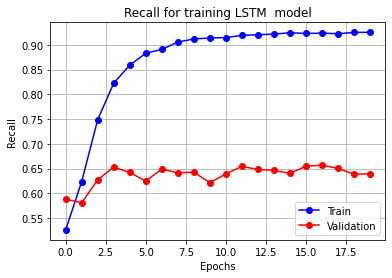

In [ ]:
plt.plot(history.history["recall"], 'b-o')
plt.plot(history.history["val_recall"], 'r-o')
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.title("Recall for training LSTM  model")
plt.legend(["Train", "Validation"])
plt.grid("on")
plt.savefig("LSTM-finetune-recall.png")

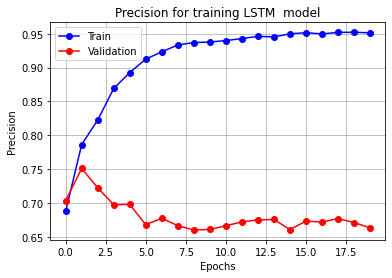

In [ ]:
plt.plot(history.history["precision"], 'b-o')
plt.plot(history.history["val_precision"], 'r-o')
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.title("Precision for training LSTM  model")
plt.legend(["Train", "Validation"])
plt.grid("on")
plt.savefig("LSTM-finetune-precision.png")

In [ ]:
model = keras.models.load_model('/content/lstm_model_best.h5')
model.evaluate(test_padded, test_label)

1/1 [==============================] - 1s 545ms/step - loss: 1.3016 - accuracy: 0.2500 - recall: 0.1500 - precision: 0.1875


[1.3016300201416016, 0.25, 0.15000000596046448, 0.1875]

##Bidirectional LSTM
---

In [ ]:
# Create LSTM model
from keras import layers
from keras import regularizers


model = keras.models.Sequential()
model.add(layers.Embedding(num_unique_words, 32, input_length=max_length, name="Embedding"))

model.add(layers.Bidirectional(layers.LSTM(64, dropout=0.2, name="Bi_LSTM_Block")))
model.add(layers.Dense(64, activation="relu", name="Hidden_Layer"))
model.add(layers.Dropout(0.2, name="Dropout"))
model.add(layers.Dense(3, activation="softmax", name="Classifier"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 29, 32)            953568    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              49664     
 l)                                                              
                                                                 
 Hidden_Layer (Dense)        (None, 64)                8256      
                                                                 
 Dropout (Dropout)           (None, 64)                0         
                                                                 
 Classifier (Dense)          (None, 3)                 195       
                                                                 
Total params: 1,011,683
Trainable params: 1,011,683
Non-trainable params: 0
____________________________________________

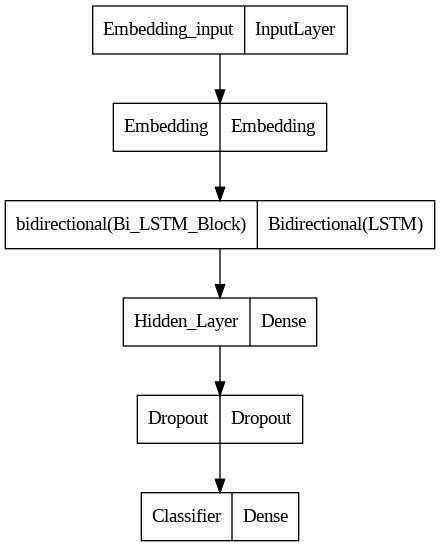

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
loss = keras.losses.CategoricalCrossentropy(from_logits=False)
optim = keras.optimizers.Adam(learning_rate=0.001)
metrics = [
        tf.keras.metrics.CategoricalAccuracy(name="accuracy", dtype=None),
        keras.metrics.Recall(name="recall"),
        keras.metrics.Precision(name="precision")
        ]
model.compile(loss=loss, optimizer=optim, metrics=metrics)
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('bilstm_model_best.h5', save_best_only=True)
]

In [ ]:
history = model.fit(train_padded, train_labels, epochs=20, validation_data=(val_padded, val_labels), verbose=2, callbacks=callbacks)

Epoch 1/20
274/274 - 11s - loss: 0.8683 - accuracy: 0.6216 - recall: 0.4879 - precision: 0.6883 - val_loss: 0.8012 - val_accuracy: 0.6587 - val_recall: 0.4961 - val_precision: 0.7563 - 11s/epoch - 39ms/step
Epoch 2/20
274/274 - 2s - loss: 0.6334 - accuracy: 0.7365 - recall: 0.6737 - precision: 0.7882 - val_loss: 0.7613 - val_accuracy: 0.6798 - val_recall: 0.6195 - val_precision: 0.7144 - 2s/epoch - 8ms/step
Epoch 3/20
274/274 - 2s - loss: 0.4318 - accuracy: 0.8370 - recall: 0.8136 - precision: 0.8605 - val_loss: 0.8359 - val_accuracy: 0.6638 - val_recall: 0.6350 - val_precision: 0.6784 - 2s/epoch - 8ms/step
Epoch 4/20
274/274 - 2s - loss: 0.2913 - accuracy: 0.8981 - recall: 0.8876 - precision: 0.9072 - val_loss: 0.9402 - val_accuracy: 0.6619 - val_recall: 0.6482 - val_precision: 0.6741 - 2s/epoch - 8ms/step
Epoch 5/20
274/274 - 2s - loss: 0.2092 - accuracy: 0.9274 - recall: 0.9229 - precision: 0.9332 - val_loss: 1.0824 - val_accuracy: 0.6405 - val_recall: 0.6272 - val_precision: 0.6519

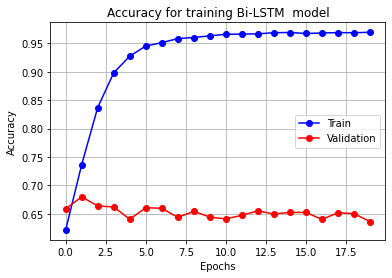

In [ ]:
plt.plot(history.history["accuracy"], 'b-o')
plt.plot(history.history["val_accuracy"], 'r-o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy for training Bi-LSTM  model")
plt.legend(["Train", "Validation"])
plt.grid("on")
plt.savefig("Bi-LSTM-finetune-accuracy.png")

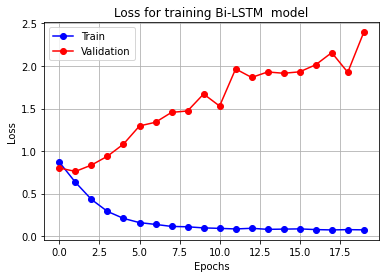

In [ ]:
plt.plot(history.history["loss"], 'b-o')
plt.plot(history.history["val_loss"], 'r-o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss for training Bi-LSTM  model")
plt.legend(["Train", "Validation"])
plt.grid("on")
plt.savefig("Bi-LSTM-finetune-loss.png")

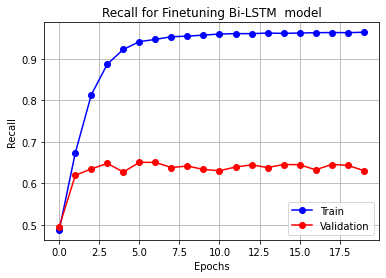

In [ ]:
plt.plot(history.history["recall"], 'b-o')
plt.plot(history.history["val_recall"], 'r-o')
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.title("Recall for Finetuning Bi-LSTM  model")
plt.legend(["Train", "Validation"])
plt.grid("on")
plt.savefig("Bi-LSTM-finetune-recall.png")

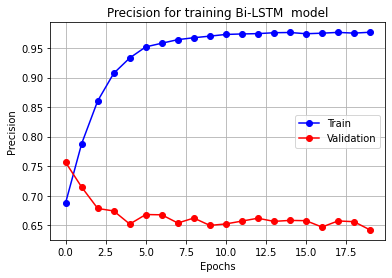

In [ ]:
plt.plot(history.history["precision"], 'b-o')
plt.plot(history.history["val_precision"], 'r-o')
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.title("Precision for training Bi-LSTM  model")
plt.legend(["Train", "Validation"])
plt.grid("on")
plt.savefig("Bi-LSTM-finetune-precision.png")

In [ ]:
model = keras.models.load_model("/content/bilstm_model_best.h5")
model.evaluate(test_padded, test_label)

1/1 [==============================] - 1s 805ms/step - loss: 1.2773 - accuracy: 0.4500 - recall: 0.2500 - precision: 0.3846


[1.2773101329803467, 0.44999998807907104, 0.25, 0.38461539149284363]